# Table of Contents

In [9]:
%%javascript
Jupyter.notebook.execute_cells([0]);

<IPython.core.display.Javascript object>

# Introduction

# Imports

In the below cell I import a variety of python libraries and modules, preparing my notebook for text analysis, natural language processing, machine learning, and more.

In [1]:
import nltk
import os
nltk.download('punkt')
from nltk.corpus import stopwords
import numpy as np
import sqlite3
from collections import Counter, defaultdict
from string import punctuation
import re
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
sw = stopwords.words('english')
import janitor
import spacy
from textblob import TextBlob
tb = TextBlob('')
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_lg')
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import interact_manual, interactive_output
from IPython.display import display, clear_output
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import spacy
from textblob import TextBlob
tb = TextBlob('')
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from random import randint
from sklearn.model_selection import RandomizedSearchCV
import winsound
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from spellchecker import SpellChecker
from textblob import TextBlob
import eli5
from eli5.sklearn import PermutationImportance
import warnings
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import words
from nltk.util import ngrams
nltk.download('words')
import random
from wordcloud import WordCloud
import xgboost as xgb
import matplotlib.dates as mdates
duration = 1000  # milliseconds
freq = 440  # Hz


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
from oarrCleaning import OARR_Clean_and_Check, cl_names

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
OARR = pd.read_csv("OA_RRA_l2.csv", encoding='latin-1')

# Basic Cleaning and Prep

In the below cells, I first utilize pyjanitor to clean the column names in the df. I then utilize a custom function that I created to perform the following tasks on the data:

- Fix an erroneous entry in the geo_area_name column
- Check the geo_area_name column for proper completion
- Ensure that each entry has a unique identifier
- Check the fire_name column and print any nan values
- Other column quality checks (see function file for a full breakdown)

In [4]:
OARR = cl_names(OARR)

In [5]:
OARR_Clean_and_Check(OARR)

The row(s) at index Index([3890, 4050, 8616, 16751, 16752, 16753, 16754, 16755, 16756, 16757], dtype='int64') have 'nan' string values in 'fire_name'.


# Process Text

In this section of the notebook I use functions I have built to process the text data in the fire reports. Below, I import said functions.

In [6]:
from text_functions import set_columns_to_string, process_text_column, categorize_columns, firestops

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
OARR = OARR.assign(wfdss_risk=(OARR['wfdss_id'].astype(str) + " - " + OARR['rrf_rr_desc']))
column_order = ['wfdss_risk'] + [col for col in OARR.columns if col != 'wfdss_risk']
OARR = OARR[column_order]

if 'unnamed_0' in OARR.columns:
    OARR = OARR.drop('unnamed_0', axis=1)

In [8]:
notes = []
for column in OARR.columns:
    if 'notes' in column:
        notes.append(column) 
        
descs = []
for column in OARR.columns:
    if 'desc' in column:
        descs.append(column)
        
ids =[]
for column in OARR.columns:
    if '_id' in column:
        ids.append(column)
        
ctk = ids + notes + descs

x_notes = notes + ['combined_text']

text_risk_id = OARR[ctk]

In [9]:
unique_sentence_dict = {col: {} for col in notes}
combined_text = []

In [10]:
grouped_df = OARR.groupby('wfdss_risk')
for fire_id, group_df in grouped_df:
    for column_name in notes:
        tokens = process_text_column(group_df, column_name)
        
        # Store the unique tokens for each column in a sub-dictionary
        unique_sentence_dict[column_name][fire_id] = tokens
        
        for token in tokens:
            if token not in combined_text:
                combined_text.append(token)

In [11]:
temp = pd.DataFrame(unique_sentence_dict)
temp.reset_index(inplace=True)
temp.rename(columns={'index': 'wfdss_risk'}, inplace=True)

for col in notes:
    temp[col] = temp[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

temp.replace("", np.nan, inplace=True)
temp['combined_text'] = temp.apply(lambda row: ' '.join(str(x) for x in row.drop(['wfdss_risk']) if isinstance(x, str)), axis=1)

In [12]:
if 'combined_text' in temp.columns:
    temp = temp.drop('combined_text', axis =1)

for col in notes:
    temp[col] = temp[col].fillna("")  
    temp[col] = temp[col].apply(lambda raw: " ".join(raw.split()) if isinstance(raw, str) else raw)
    temp[col] = temp[col].apply(lambda raw: " ".join([t.lower() for t in raw.split() if t.lower().isalpha() and t.lower() not in sw and t.lower() not in firestops]) if isinstance(raw, str) else "")

In [13]:
grouped_df2 = OARR.groupby('wfdss_risk')

In [14]:
def get_last_value(col):
    unique_values = col.unique()
    if len(unique_values) > 1:
        return col.iloc[-1]
    else:
        return unique_values[0]

In [15]:
result_df = grouped_df2.apply(lambda group: group.apply(get_last_value))

result_df.reset_index(drop=True, inplace=True)


In [16]:
for column in notes:
    result_df[column] = temp[column]
data = result_df
data['combined_text'] = data[[col for col in notes]].apply(lambda row: ' '.join(row), axis=1)

In [17]:
for id_ in data['wfdss_risk'].unique():
    mask = data['wfdss_risk'] == id_

    for col in notes:
        for i, row in data[mask].iterrows():
            if i > 0 and not pd.isnull(row[col]) and not pd.isnull(data.loc[i - 1, col]):
                previous_text = data.loc[i - 1, col]
                current_text = row[col]
                new_text = current_text.replace(previous_text, '').strip()
                data.at[i, col] = new_text

data['combined_text'] = data[notes].apply(lambda row: ' '.join(row), axis=1)


# Text Overview

### Common Tokens

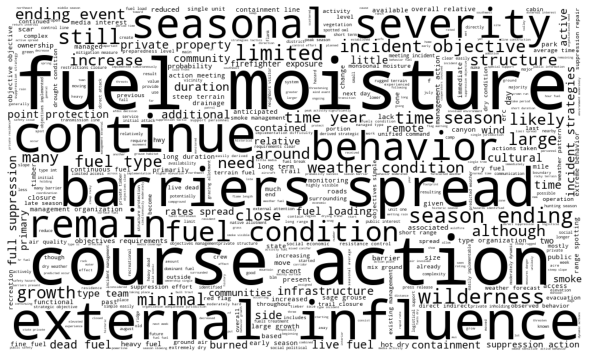

In [18]:
all_text = "".join(data['combined_text'])
text = all_text

colors = ["#000000"]

wordcloud = WordCloud(background_color="white", max_words=500, width=1000, height=600,
                      color_func=lambda *args, **kwargs: colors[0])

wordcloud.generate(all_text)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Common N-grams

In [19]:
def count_ngrams(text, n):
    tokens = word_tokenize(text)  
    n_grams = ngrams(tokens, n)
    n_gram_freq = Counter(n_grams)
    sorted_n_grams = dict(sorted(n_gram_freq.items(), key=lambda item: item[1], reverse=True))
    
    
    return sorted_n_grams

In [20]:
result = count_ngrams(text, 2)

In [21]:
count = 0
for n_gram, frequency in result.items():
    if count < 15:
        print(f"{n_gram}: {frequency} times")
        count += 1
    else:
        break

('course', 'action'): 2360 times
('barriers', 'spread'): 2348 times
('external', 'influences'): 2233 times
('seasonal', 'severity'): 1994 times
('fuel', 'moistures'): 1636 times
('season', 'ending'): 1581 times
('incident', 'objectives'): 1391 times
('fuel', 'conditions'): 1355 times
('time', 'season'): 1350 times
('time', 'year'): 1149 times
('weather', 'conditions'): 1079 times
('private', 'property'): 1077 times
('incident', 'strategies'): 1070 times
('ending', 'event'): 1038 times
('fuel', 'moisture'): 1024 times


## Broad Data Information

In [22]:
def completion_percentage(df, columns_to_process):
    completion_dict = {}

    for column in columns_to_process:
        total_count = len(df)
        non_empty_count = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x).replace('', pd.NA).notna().sum()
        
        if total_count > 0:
            perc_completion = non_empty_count / total_count * 100
        else:
            perc_completion = 0
        
        completion_dict[column] = perc_completion
    print("Below is the percantage of entires with at least some unique text for a fire-risk grouping:")
    return completion_dict

def basic_text(df, columns_to_process):
    results = {}
    
    for column in columns_to_process:
        concatenated_text = df[column].astype(str).str.cat(sep=' ')

        text_clean = [word for word in concatenated_text.split()]
        c = Counter(text_clean)

        total_tokens = len(text_clean)
        unique_tokens = len(set(text_clean))

        lex_diversity = unique_tokens / total_tokens if total_tokens != 0 else "NA"
        avg_token_len = np.mean([len(word) for word in text_clean])
        top_10 = c.most_common(10)

        avg_tokens_per_entry = df[column].apply(lambda x: len(str(x).split())).mean()
        
        
        results[column] = {
            'total_tokens': total_tokens,
            'unique_tokens': unique_tokens,
            'average_tokens' : avg_tokens_per_entry,
            'avg_token_length': avg_token_len,
            'lexical_diversity': lex_diversity,
            'top_10': top_10,
        }
    results_df = pd.DataFrame(results)
    return results_df

def input_with_timeout(prompt, timeout):
    import select
    import sys

    print(prompt)
    sys.stdout.flush()
    rlist, _, _ = select.select([sys.stdin], [], [], timeout)
    if rlist:
        return input().strip()
    else:
        return None

### Completion of  Notes Fields

In [23]:
completion_percentage(data,notes)

Below is the percantage of entires with at least some unique text for a fire-risk grouping:


{'hazf_notes': 91.29810828440965,
 'probf_notes': 88.81930854533594,
 'valf_notes': 91.1545988258317,
 'rrf_notes': 86.43183300717547,
 'spf_notes': 85.58382257012394,
 'impdif_f_notes': 87.71037181996087,
 'orgf_notes': 72.56360078277886}

### Summary Statistics of Notes Fields

In [24]:
results_df = basic_text(data,notes)
results_df.transpose()

,total_tokens,unique_tokens,average_tokens,avg_token_length,lexical_diversity,top_10
hazf_notes,193483,6148,25.242401,6.543438,0.031775,"[(fuel, 6516), (behavior, 5146), (fuels, 5086)..."
probf_notes,158328,6007,20.655969,6.502558,0.03794,"[(barriers, 5283), (season, 4599), (spread, 34..."
valf_notes,190057,9795,24.795434,6.934435,0.051537,"[(private, 3395), (cultural, 2331), (infrastru..."
rrf_notes,146982,6998,19.175734,6.868399,0.047611,"[(relative, 2340), (fuel, 1637), (fuels, 1632)..."
spf_notes,139675,6767,18.22244,7.315132,0.048448,"[(objectives, 3843), (private, 2847), (externa..."
impdif_f_notes,161584,6032,21.080757,7.199958,0.03733,"[(incident, 2533), (functional, 2336), (limite..."
orgf_notes,139169,6942,18.156425,7.213237,0.049882,"[(type, 2667), (objectives, 2375), (incident, ..."


In [25]:
at_results = basic_text(data,['combined_text'])
at_results.transpose()

,average_tokens,avg_token_length,lexical_diversity,top_10,total_tokens,unique_tokens
combined_text,147.329159,6.917737,0.015104,"[(fuel, 12415), (fuels, 10156), (private, 9326...",1129278,17057


# Regional Differences

### Risk

C:\Users\aidan\AppData\Local\Temp\ipykernel_5360\1307532202.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.histplot(


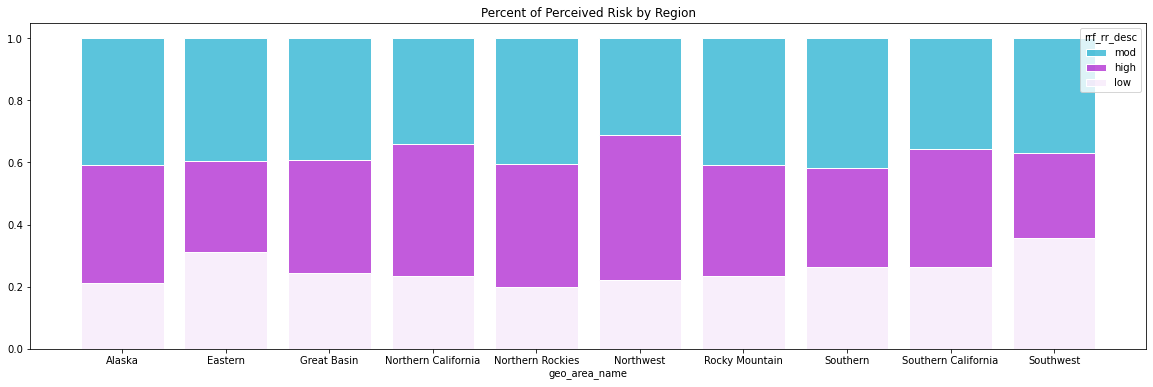

In [26]:
df_grouped = data.groupby(['geo_area_name', 'rrf_rr_desc']).size().reset_index(name='count')

region_total = df_grouped.groupby('geo_area_name')['count'].sum()
df_merged = pd.merge(df_grouped, region_total, left_on='geo_area_name', right_index=True, suffixes=('', '_total'))
df_merged['percent'] = df_merged['count'] / df_merged['count_total']
df_result = df_merged[['count', 'geo_area_name', 'rrf_rr_desc', 'percent']].sort_values(['geo_area_name', 'count'], ascending=[True, False])

ax = sns.histplot(
    df_result,
    x='geo_area_name',
    weights='percent',
    hue='rrf_rr_desc',
    multiple='stack',
    palette=['#24b1d1', '#ae24d1','#f6e9fa','#47d124'],
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.8   
)

ax.set_title('Percent of Perceived Risk by Region')
# Remove 'Count' ylabel.
ax.set_ylabel(None)

fig = ax.get_figure()
fig.set_size_inches(20, 6)

In [27]:
df_result['total_fire'] = df_result.groupby('geo_area_name')['count'].transform('sum')
df3 = df_result[df_result['rrf_rr_desc'] == ("high")]
x = df3['total_fire'].corr(df3['percent'])
print("The percentage of fires designated as high risk has a correlation coefficient of " + str(round(x,6)) + " with the number of total fires")

The percentage of fires designated as high risk has a correlation coefficient of 0.290057 with the number of total fires


### Text

##### Disproportionate Tokens

In [28]:
valid_word_set = set(words.words())

regions = data['geo_area_name'].unique()
region_texts = {region: " ".join(data[data['geo_area_name'] == region]['combined_text']) for region in regions}

region_token_freqs = {region: FreqDist(word_tokenize(text.lower())) for region, text in region_texts.items()}

tokens_relative_freq = {}

for region, freq_dist in region_token_freqs.items():
    other_regions_freq = {other_region: FreqDist(word_tokenize(text.lower())) for other_region, text in region_texts.items() if other_region != region}
    
    tokens_relative_freq[region] = {}
    for token, freq in freq_dist.items():
        other_regions_total_freq = sum([other_freq[token] for other_freq in other_regions_freq.values() if token in other_freq])
        relative_freq = freq / (other_regions_total_freq + freq) 
        
        tokens_relative_freq[region][token] = relative_freq

for region, token_freqs in tokens_relative_freq.items():
    text = region_texts[region]  
    tokens = word_tokenize(text.lower())  
    
    region_freq_dist = FreqDist(tokens) 
    
    top_words = [{'word': word, 'freq': freq, 'count': region_freq_dist[word]} for word, freq in token_freqs.items() if word.isalpha() and word.lower() in valid_word_set and region_freq_dist[word] > 10 and freq < 1.0]
    top_words = sorted(top_words, key=lambda x: x['freq'], reverse=True)[:10]
    
    print(f"Region {region}: Top Valid Words (Appearing >10 times) with Frequencies and Counts:")
    for word_info in top_words:
        word = word_info['word']
        word_freq = word_info['freq']
        word_count = word_info['count']
        print(f"'{word}' (Frequency: {word_freq}, Count: {word_count})")
    print()

Region Southern: Top Valid Words (Appearing >10 times) with Frequencies and Counts:
'arson' (Frequency: 0.9047619047619048, Count: 19)
'stumpy' (Frequency: 0.9, Count: 18)
'canal' (Frequency: 0.875, Count: 14)
'parkway' (Frequency: 0.8666666666666667, Count: 13)
'swamp' (Frequency: 0.8305084745762712, Count: 49)
'cypress' (Frequency: 0.8301886792452831, Count: 44)
'irene' (Frequency: 0.8125, Count: 13)
'clay' (Frequency: 0.7857142857142857, Count: 11)
'organic' (Frequency: 0.7065217391304348, Count: 65)
'outer' (Frequency: 0.6875, Count: 11)

Region Southwest: Top Valid Words (Appearing >10 times) with Frequencies and Counts:
'apache' (Frequency: 0.9821428571428571, Count: 110)
'fe' (Frequency: 0.9629629629629629, Count: 26)
'sunflower' (Frequency: 0.9615384615384616, Count: 25)
'outlet' (Frequency: 0.9473684210526315, Count: 18)
'cuckoo' (Frequency: 0.9333333333333333, Count: 14)
'calf' (Frequency: 0.9285714285714286, Count: 13)
'mesquite' (Frequency: 0.9285714285714286, Count: 13)
'c

## Tokens of Interest

###### Set target words below!

In [29]:
target_words = ["suppression", "containment", "structure", "communities", "barriers", "smoke"]

In [30]:
def contains_target_word(text, target_word):
    return target_word in text

def percentage_with_target_words(data, target_words):
    percentage_with_target_words = {}

    data_copy = data.copy()

    for word in target_words:
        data_copy[f'contains_{word}'] = data_copy['combined_text'].apply(contains_target_word, target_word=word)
        percentage_with_target_words[word] = (data_copy[f'contains_{word}'].sum() / len(data_copy)) * 100
        data_copy.drop(columns=[f'contains_{word}'], inplace=True)

    sorted_results = sorted(percentage_with_target_words.items(), key=lambda x: x[1], reverse=True)

    for word, percentage in sorted_results:
        print(f"The word '{word}' appears in {percentage:.2f}% of the combined notes fields for fires.")
        
def percentage_by_risk(data, target_words):
    results_by_risk = {}

    data_copy = data.copy()

    custom_order = ['high', 'mod', 'low']

    grouped_data = data_copy.groupby('rrf_rr_desc', sort=False)  # Use sort=False to maintain custom order

    for risk, group in grouped_data:
        percentage_with_target_words = {}
        for word in target_words:
            group[f'contains_{word}'] = group['combined_text'].apply(contains_target_word, target_word=word)
            percentage_with_target_words[word] = (group[f'contains_{word}'].sum() / len(group)) * 100
            group.drop(columns=[f'contains_{word}'], inplace=True)
        results_by_risk[risk] = percentage_with_target_words

    for risk in custom_order:
        if risk in results_by_risk:
            percentages = results_by_risk[risk]
            print(f"Risk: {risk.capitalize()}")
            for word, percentage in sorted(percentages.items(), key=lambda x: x[1], reverse=True):
                print(f"The word '{word}' appears in {percentage:.2f}% of the texts for this risk.")
            print()

            
            
            
def extract_context(text, target_word, context_window_size = 5):
    words = text.split()
    target_indices = [i for i, word in enumerate(words) if word.lower() == target_word]
    
    contexts = []
    for index in target_indices:
        start_index = max(0, index - context_window_size)
        end_index = min(len(words), index + context_window_size + 1)
        context = words[start_index:end_index]
        contexts.append(context)
    
    return contexts

def extract_ordered_ngrams(context_list, n =3):
    ordered_trigrams = []
    for context in context_list:
        ordered_trigrams.extend(" ".join(context[i:i+n]) for i in range(len(context) - 2))
    return ordered_trigrams

In [31]:
toi = data[x_notes + descs]

### How often do they appear?

In [32]:
percentage_with_target_words(toi,target_words)

The word 'barriers' appears in 51.64% of the combined notes fields for fires.
The word 'structure' appears in 40.03% of the combined notes fields for fires.
The word 'smoke' appears in 32.41% of the combined notes fields for fires.
The word 'suppression' appears in 32.13% of the combined notes fields for fires.
The word 'containment' appears in 16.37% of the combined notes fields for fires.
The word 'communities' appears in 13.07% of the combined notes fields for fires.


In [33]:
percentage_by_risk(toi, target_words)

Risk: High
The word 'barriers' appears in 58.63% of the texts for this risk.
The word 'structure' appears in 52.03% of the texts for this risk.
The word 'suppression' appears in 38.99% of the texts for this risk.
The word 'smoke' appears in 32.22% of the texts for this risk.
The word 'communities' appears in 19.36% of the texts for this risk.
The word 'containment' appears in 16.46% of the texts for this risk.

Risk: Mod
The word 'barriers' appears in 48.79% of the texts for this risk.
The word 'structure' appears in 35.42% of the texts for this risk.
The word 'smoke' appears in 32.31% of the texts for this risk.
The word 'suppression' appears in 31.20% of the texts for this risk.
The word 'containment' appears in 16.52% of the texts for this risk.
The word 'communities' appears in 10.21% of the texts for this risk.

Risk: Low
The word 'barriers' appears in 45.48% of the texts for this risk.
The word 'smoke' appears in 32.85% of the texts for this risk.
The word 'structure' appears in 

### What is the context surrounding them?

In [34]:
con_dict = {}  
context_words_dict_alpha = {}  
context_window_size = 5

for word in target_words:
    con_dict[word] = {}
    context_words_dict_alpha[word] = {}  # Initialize context_words_dict_alpha[word] as an empty dictionary
    
    for index, row in toi.iterrows():
        text = row['combined_text']

        if 'default_risk' not in con_dict[word]:
            con_dict[word]['default_risk'] = []

        contexts = extract_context(text, word, context_window_size)
        con_dict[word]['default_risk'].extend(contexts)
        
    for risk_description, c in con_dict[word].items():
        all_words = [w.lower() for context in c for w in context if not w.lower() == word]
        common_words = Counter(all_words).most_common(5)  # Change 5 to the desired number of common words
        context_words_dict_alpha[word]['default_risk'] = common_words

In [35]:
def plot_function(word):
    plt.figure(figsize=(8, 6))
    
    # Ensure there is data for the given token in the dictionary
    if 'default_risk' in context_words_dict_alpha.get(word, {}):  # Updated from cwd
        common_words, counts = zip(*context_words_dict_alpha[word]['default_risk'])  # Updated from cwd
        plt.bar(common_words, counts)
        plt.title(f"Common Tokens appearing in Context for '{word}'")  # Updated title
        plt.xlabel("Words")
        plt.ylabel("Count")
        plt.show()
    else:
        print(f"No data available for combined text for {word}")

# Create buttons for user interaction
word_buttons = [widgets.Button(description=word) for word in target_words]

def button_click_handler(button):
    with output_area:
        clear_output(wait=True)
        plot_function(button.description)

for button in word_buttons:
    button.on_click(button_click_handler)

# Populate interactive buttons
button_box = widgets.HBox(word_buttons)
display(button_box)

# Make a separate area for the plots to show up
output_area = widgets.Output()

# Display the plots
display(output_area)

with output_area:
    random_button = random.choice(word_buttons)
    plot_function(random_button.description)

Output()

###### By Risk

In [36]:
con_risk_dict = {}  # Updated from conDict
context_words_dict = {}  # Updated from cwd
context_window_size = 5

for word in target_words:
    con_risk_dict[word] = {}
    context_words_dict[word] = {}  # Initialize context_words_dict[word] as an empty dictionary
    
    for index, row in toi.iterrows():
        risk_description = row['rrf_rr_desc']
        text = row['combined_text']

        if risk_description not in con_risk_dict[word]:
            con_risk_dict[word][risk_description] = []

        contexts = extract_context(text, word, context_window_size)
        con_risk_dict[word][risk_description].extend(contexts)
        
    for risk_description, c in con_risk_dict[word].items():
        all_words = [w.lower() for context in c for w in context if not w.lower() == word]
        common_words = Counter(all_words).most_common(5)  # Change 5 to the desired number of common words
        context_words_dict[word][risk_description] = common_words
        
for word, risk_descriptions in context_words_dict.items():
    print(f"Word: {word}")
    for risk_description, common_words in risk_descriptions.items():
        print(f"  Risk Description: {risk_description}")
        print("    Common Words:")
        for word, count in common_words:
            print(f"      {word}: {count}")

Word: suppression
  Risk Description: mod
    Common Words:
      full: 333
      actions: 300
      incident: 234
      efforts: 233
      objectives: 217
  Risk Description: high
    Common Words:
      full: 871
      objectives: 536
      incident: 433
      actions: 382
      strategy: 326
  Risk Description: low
    Common Words:
      repair: 298
      actions: 195
      efforts: 134
      incident: 103
      objectives: 98
Word: containment
  Risk Description: mod
    Common Words:
      lines: 250
      suppression: 147
      spread: 122
      barriers: 114
      reduced: 108
  Risk Description: high
    Common Words:
      lines: 195
      growth: 114
      barriers: 101
      spread: 88
      conditions: 86
  Risk Description: low
    Common Words:
      lines: 252
      suppression: 94
      behavior: 91
      spread: 91
      growth: 82
Word: structure
  Risk Description: mod
    Common Words:
      protection: 135
      historic: 40
      one: 37
      conditions: 37
    

In [37]:
def plot_risks(word):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Ensure there is data for the given token in the dictionary
    if word in context_words_dict:
        # Sort risk descriptions based on counts
        sorted_risks = sorted(context_words_dict[word].items(), key=lambda x: sum(count for word, count in x[1]), reverse=True)

        for ax, (risk_description, common_words) in zip(axes, sorted_risks):
            words, counts = zip(*common_words)
            ax.bar(words, counts)
            ax.set_title(risk_description)
            ax.set_xlabel("Words")
            ax.set_ylabel("Count")

        plt.show()
    else:
        print(f"No data available for combined text for {word}")

# Create buttons for user interaction
word_buttons = [widgets.Button(description=word, layout=Layout(width='100px')) for word in target_words]

# Function to handle button click
def button_click_handler(button):
    with output_area:
        clear_output(wait=True)
        plot_risks(button.description)

# Assign a random button to be clicked automatically
random_button = random.choice(word_buttons)
button_click_handler(random_button)

# Attach click handler to buttons
for button in word_buttons:
    button.on_click(button_click_handler)

# Populate interactive buttons
button_box = widgets.HBox(word_buttons)
display(button_box)

# Make a separate area for the plots to show up
output_area = widgets.Output()

# Display the plots
display(output_area)

# Use plot function to display plot
with output_area:
    plot_risks(random_button.description)

Output()

### Let's take a look at common ngrams

In [38]:
common_ordered_ngrams_by_risk = {}

for word in target_words:
    common_ordered_ngrams_by_risk[word] = {}
    for risk_description, contexts in con_risk_dict[word].items(): 

        ordered_ngrams = extract_ordered_ngrams(contexts, 3)

        ordered_ngram_counts = Counter(ordered_ngrams)

        most_common_ordered_ngrams = ordered_ngram_counts.most_common(10)

        common_ordered_ngrams_by_risk[word][risk_description] = most_common_ordered_ngrams

for word, risk_descriptions in common_ordered_ngrams_by_risk.items():
    print(f"Word: {word}")
    for risk_description, ngram_counts in risk_descriptions.items():
        print(f"  Risk Description: {risk_description}")
        print("    Most Common Ordered Ngrams:")
        for ngram, count in ngram_counts:
            print(f"      {ngram}: {count}")
        print()  # Add an empty line between risk descriptions
    print()  # Add an empty line between words

Word: suppression
  Risk Description: mod
    Most Common Ordered Ngrams:
      full suppression strategy: 50
      suppression actions taken: 29
      conditions shortages suppression: 25
      likelihood success least: 25
      unusual conditions shortages: 24
      shortage suppression response: 23
      shortages suppression shortage: 22
      suppression shortage suppression: 22
      appropriate suppression protect: 22
      suppression protect cultural: 20

  Risk Description: high
    Most Common Ordered Ngrams:
      full suppression smallest: 143
      full suppression strategy: 128
      suppression smallest possible: 114
      objectives full suppression: 105
      full suppression objectives: 87
      conflict full suppression: 84
      suppression objectives full: 72
      involved coordinated suppression: 60
      strategies full suppression: 59
      conducive highly involved: 56

  Risk Description: low
    Most Common Ordered Ngrams:
      suppression repair work: 21


# Topic Modeling

# Sentiment Analyses 

## Sentiment in Relationship to Risk Decision

# Risk Classification - Individual Tokens

In [39]:
risk_levels = data['rrf_rr_desc'].value_counts()
risk_levels

rrf_rr_desc
mod     2888
high    2862
low     1915
Name: count, dtype: int64

Placeholder Text

## Relative Risk Decision and All Text

In this section of the notebook, I explore using the combined text for each fire-risk combination to predict risk. By doing so, I am hopeful that I can gain insight into tokens potentially driving risk decisions. I'll explore different techniques, ensembles, and whatever is necessary to produce the most accurate model.

In [40]:
combined_texts = data['combined_text']
risk_labels = data['rrf_rr_desc']

for label in risk_labels:
    if label not in ["high", "mod", "low"]:
        print("Within the data, there is a risk label that is erroneous. This should be looked into as soon as possible")

vectorizer =TfidfVectorizer()

Explain Why I am doing

In [41]:
high_other = data.copy()
high_other['rrf_rr_desc'] = high_other['rrf_rr_desc'].apply(lambda x: 'other' if x in ['low', 'mod'] else x)

high_other_comb_texts = high_other['combined_text']
high_other_labels = high_other['rrf_rr_desc']

### Naive Bayes

Placeholder Text to describe what is happening

In [42]:
def train_nb_classifier(combined_texts=None, risk_labels=None, test_size=0.2, alpha = 1.0, random_state=2):
    vectorizer = TfidfVectorizer()

    x_nb = vectorizer.fit_transform(combined_texts)
    y_nb = risk_labels

    x_nb_train, x_nb_test, y_nb_train, y_nb_test = train_test_split(x_nb, y_nb, test_size=test_size, random_state=random_state)

    nb_classifier = MultinomialNB(alpha= alpha)
    nb_classifier.fit(x_nb_train, y_nb_train)

    return nb_classifier, x_nb_train, x_nb_test, y_nb_train, y_nb_test



#### 3 Risks

In [43]:
nb_classifier, x_nb_train, x_nb_test, \
y_nb_train, y_nb_test = train_nb_classifier(combined_texts,risk_labels,.2,1,2);

In [44]:
y_nb_pred = nb_classifier.predict(x_nb_test)
y_nb_train_pred = nb_classifier.predict(x_nb_train)

nb_accuracy = accuracy_score(y_nb_test, y_nb_pred)

print(f"The Naive Bayes classifier accuracy is {nb_accuracy:.4f} or {nb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_nb_test, y_nb_pred))


The Naive Bayes classifier accuracy is 0.5388 or 53.88%


Classification Report:
              precision    recall  f1-score   support

        high       0.63      0.81      0.71       552
         low       0.56      0.01      0.02       400
         mod       0.46      0.64      0.53       581

    accuracy                           0.54      1533
   macro avg       0.55      0.49      0.42      1533
weighted avg       0.55      0.54      0.46      1533



###### Thoughts

In this three class model, the model performs better than chance guessing. This is a start! However, I am not satisfied with the performance of the model. The macro average of f1-score being .42 is not where I would like it to be by any means. It is interesting thast the model performs significantly better on predicting high risk fires versus low, or moderate risk fires. It is also interesting just how poorly the model performs predicting low risk fires.

#### High vs Mod + Low

In [45]:
honb_classifier, x_honb_train, x_honb_test, \
y_honb_train, y_honb_test = train_nb_classifier(high_other_comb_texts, high_other_labels, 0.2)

In [46]:
y_honb_pred = honb_classifier.predict(x_honb_test)
y_honb_train_pred = honb_classifier.predict(x_honb_train)

honb_accuracy = accuracy_score(y_honb_test, y_honb_pred)

print(f"The Naive Bayes classifier accuracy is {honb_accuracy:.4f} or {honb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_honb_test, y_honb_pred))

The Naive Bayes classifier accuracy is 0.6960 or 69.60%


Classification Report:
              precision    recall  f1-score   support

        high       0.84      0.19      0.31       552
       other       0.68      0.98      0.80       981

    accuracy                           0.70      1533
   macro avg       0.76      0.59      0.56      1533
weighted avg       0.74      0.70      0.63      1533



### K Nearest Neighbors

In [47]:
def train_knn_classifier(combined_texts=None, risk_labels=None, neighbors = 6, test_size=0.2, random_state=2):
    x = vectorizer.fit_transform(combined_texts)
    y = risk_labels.tolist()
    xnn_train, xnn_test, ynn_train, ynn_test = train_test_split(x,y,test_size = 0.2, random_state = 2)
    knn_fire = KNeighborsClassifier(n_neighbors = neighbors)
    knn_fire.fit(xnn_train, ynn_train)
    
    return knn_fire, xnn_train, xnn_test, ynn_train, ynn_test

def neighbor_number_search(min, max):
    n_rng = np.arange(min,max)
    train_acc = np.empty(len(n_rng))
    test_acc = np.empty(len(n_rng))
    
    for i, k in enumerate(n_rng):
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(xnn_train, ynn_train)
        
        train_acc[i] = knn.score(xnn_train, ynn_train)
        test_acc[i] = knn.score(xnn_test, ynn_test)
    
    plt.plot(n_rng, test_acc, label = 'Accuracy on Testing Data')
    plt.plot(n_rng, train_acc, label = 'Accuracy on Training Data')
    plt.legend()
    plt.xlabel('# of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()
    

In [48]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors._classification")

knn_classifier, xnn_train, xnn_test, ynn_train, ynn_test \
    = train_knn_classifier(combined_texts, risk_labels, 6, .2, 2)

In [49]:
knn_pred = knn_classifier.predict(xnn_test)

In [50]:
knn_score = knn_classifier.score(xnn_test,ynn_test)
print(knn_score)

0.3561643835616438


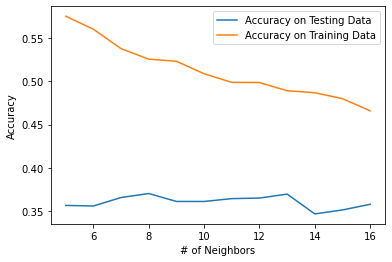

In [51]:
neighbor_number_search(5,17)

### Penalized Logistic Regression

In [52]:
def train_linear_reg(text, labels, penalty = 'l2', C = 1, max_iter = 500):
    x = vectorizer.fit_transform(text)
    y = labels.tolist()
    
    lrx_train, lrx_test, lry_train, lry_test = train_test_split(x, y, test_size = 0.2, random_state = 2)
    
    model = LogisticRegression(penalty = penalty, C = C, random_state = 2, max_iter = max_iter)
    model.fit(lrx_train,lry_train)
    
    return(model, lrx_train, lrx_test, lry_train, lry_test)
    
    
    

#### 3 Risks

In [53]:
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_linear_reg(combined_texts,risk_labels,'l2',1,1000)

In [54]:
lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)

In [55]:
print(f"A penalized linear regression model classifying risk has an accuracy of {plr_score}\n")
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized linear regression model classifying risk has an accuracy of 0.6060013046314416

Classification Report:
              precision    recall  f1-score   support

        high       0.69      0.75      0.72       552
         low       0.64      0.46      0.54       400
         mod       0.51      0.56      0.54       581

    accuracy                           0.61      1533
   macro avg       0.61      0.59      0.60      1533
weighted avg       0.61      0.61      0.60      1533



#### High vs Mod + Low

In [56]:
ho_model, ho_lrx_train, ho_lrx_test, ho_lry_train, ho_lry_test \
= train_linear_reg(high_other_comb_texts, high_other_labels, 'l2', 1, 1000)

In [57]:
ho_lry_pred = ho_model.predict(ho_lrx_test)
ho_score = accuracy_score(ho_lry_test, ho_lry_pred)

In [58]:
print(f"The model accuracy is {ho_score}")
print(" \nClassification Report:")
print(classification_report(ho_lry_test, ho_lry_pred))

The model accuracy is 0.7964774951076321
 
Classification Report:
              precision    recall  f1-score   support

        high       0.77      0.62      0.69       552
       other       0.81      0.90      0.85       981

    accuracy                           0.80      1533
   macro avg       0.79      0.76      0.77      1533
weighted avg       0.79      0.80      0.79      1533



### Random Forest 

In [59]:
def train_random_forest(text,labels,n_estimators = 500):
    x = vectorizer.fit_transform(text)
    y = labels.tolist()
    
    rfx_train, rfx_test, rfy_train, rfy_test = train_test_split(x, y, test_size = 0.2, random_state = 2)
    rf_classifier = RandomForestClassifier(n_estimators= n_estimators, random_state = 2)
    rf_classifier.fit(rfx_train, rfy_train)
    
    return(rf_classifier,rfx_train, rfx_test, rfy_train, rfy_test)

def best_random_forest(text, labels, n_estimators=500):
    x = vectorizer.fit_transform(text)
    y = labels.tolist()
    
    rfx_train, rfx_test, rfy_train, rfy_test = train_test_split(x, y, test_size=0.2, random_state=2)
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=2)


    param_grid = {
        'n_estimators': [100, 500, 1000, 2000],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10, 20, 30],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(rfx_train, rfy_train)

    # Get the best model from grid search
    best_rf_classifier = grid_search.best_estimator_

    return best_rf_classifier, rfx_train, rfx_test, rfy_train, rfy_test

In [60]:
rf_classifier,rfx_train, rfx_test, rfy_train, rfy_test = train_random_forest(combined_texts,risk_labels)

In [61]:
rfy_pred = rf_classifier.predict(rfx_test)
rf_accuracy = accuracy_score(rfy_test, rfy_pred)
print("Accuracy:", rf_accuracy)

Accuracy: 0.5649054142204827


In [62]:
 print("Classification Report:\n", classification_report(rfy_test, rfy_pred))

Classification Report:
               precision    recall  f1-score   support

        high       0.63      0.78      0.70       552
         low       0.66      0.30      0.41       400
         mod       0.47      0.55      0.51       581

    accuracy                           0.56      1533
   macro avg       0.59      0.54      0.54      1533
weighted avg       0.58      0.56      0.55      1533



Now, I try some hyperparamater tuning to see if model performance can be improved without overfitting.

In [63]:
#best_rf_classifier, rfx_train, rfx_test, rfy_train, rfy_test = best_random_forest(combined_texts, risk_labels)
#rfy_pred = best_rf_classifier.predict(rfx_test)
#brf_accuracy = accuracy_score(rfy_test, rfy_pred)
#print("Best Model Accuracy:", brf_accuracy)
#print("Best Model Parameters:", best_rf_classifier.get_params())

### Ensemble

In [64]:
from sklearn.ensemble import StackingClassifier
x = vectorizer.fit_transform(combined_texts)
y = risk_labels.tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)

#### Base Models

#####  Naive Bayes

In [65]:
en_nb_classifier,*_ = train_nb_classifier(combined_texts,risk_labels,.2)

y_pred_nb = en_nb_classifier.predict(x_test)

classification_rep = classification_report(y_test, y_pred_nb)

print("Classification Report for Naive Bayes Classifier:")
print(classification_rep)

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

        high       0.63      0.81      0.71       552
         low       0.56      0.01      0.02       400
         mod       0.46      0.64      0.53       581

    accuracy                           0.54      1533
   macro avg       0.55      0.49      0.42      1533
weighted avg       0.55      0.54      0.46      1533



In [66]:
en_bestalpha_nb_classifier, *_ = train_nb_classifier(combined_texts,risk_labels,.2,.1)

y_pred_nb = en_bestalpha_nb_classifier.predict(x_test)

classification_rep = classification_report(y_test, y_pred_nb)

print("Classification Report for Naive Bayes Classifier:")
print(classification_rep)

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

        high       0.64      0.71      0.67       552
         low       0.58      0.29      0.39       400
         mod       0.47      0.58      0.52       581

    accuracy                           0.55      1533
   macro avg       0.56      0.53      0.53      1533
weighted avg       0.56      0.55      0.54      1533



##### Random Forest

In [67]:
en_rf_classifier, *_ = train_random_forest(combined_texts, risk_labels,750) 

###### Penalized Linear Regression

In [68]:
en_plr_model, *_ = train_linear_reg(combined_texts,risk_labels)

#### Stacker Model

In [69]:
estimators = [('PLR',en_plr_model),('RF', en_rf_classifier), ('NB', en_nb_classifier), ('NB_alpha', en_bestalpha_nb_classifier)]
stacker = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacker.fit(x_train,y_train)

StackingClassifier(estimators=[('PLR',
                                LogisticRegression(C=1, max_iter=500,
                                                   random_state=2)),
                               ('RF',
                                RandomForestClassifier(n_estimators=750,
                                                       random_state=2)),
                               ('NB', MultinomialNB()),
                               ('NB_alpha', MultinomialNB(alpha=0.1))],
                   final_estimator=LogisticRegression())

In [70]:
stack_pred = stacker.predict(x_test)

stack_score = accuracy_score(y_test, stack_pred)

stack_score

0.6353555120678408

In [71]:
from scipy.stats import mode

In [76]:
accuracy = accuracy_score(y_test_encoded, predictions)

# Filter probabilities for correct and incorrect classifications
correct_probabilities = probabilities[predictions == y_test_encoded]
incorrect_probabilities = probabilities[predictions != y_test_encoded]

sns.set(style="whitegrid")

# Plot histograms for correct and incorrect probabilities
plt.figure(figsize=(12, 6))

# Plot histogram for correct probabilities
plt.subplot(1, 2, 1)
plt.hist(correct_probabilities.flatten(), bins=20, color='green', alpha=0.7)
plt.title('Correct Classifications')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')

# Plot histogram for incorrect probabilities
plt.subplot(1, 2, 2)
plt.hist(incorrect_probabilities.flatten(), bins=20, color='red', alpha=0.7)
plt.title('Incorrect Classifications')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

print(accuracy)

NameError: name 'predictions' is not defined

####  Boosting

In [74]:
def train_binary_classifier(x_train, y_train, class_label):
    model = OneVsRestClassifier(LogisticRegression())
    model.fit(x_train, (y_train == class_label).astype(int))
    return model
from sklearn.svm import SVC

In [75]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model_level1 = train_binary_classifier(x_train, y_train_encoded, 0)
model_level2 = train_binary_classifier(x_train, y_train_encoded, 1)
model_level3 = train_binary_classifier(x_train, y_train_encoded, 2)


# Make predictions
pred_level1 = model_level1.predict_proba(x_test)[:, 1]  # Probability of class 1
pred_level2 = model_level2.predict_proba(x_test)[:, 1]  # Probability of class 1
pred_level3 = model_level3.predict_proba(x_test)[:, 1]  # Probability of class 1

highest_probability_class = np.argmax([pred_level1, pred_level2, pred_level3], axis=0)

# Train XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train_encoded)

# Train SVM model
svm_model = SVC(probability=True)
svm_model.fit(x_train, y_train_encoded)

# Make predictions
xgb_predictions = xgb_model.predict(x_test)
svm_predictions = svm_model.predict(x_test)

# Combine predictions using majority voting
ensemble_prediction = np.argmax([highest_probability_class, xgb_predictions, svm_predictions], axis=0)

# Initialize ensemble_predictions
ensemble_predictions = np.copy(ensemble_prediction)

# Print ensemble predictions
print("Ensemble Prediction:")
print(ensemble_prediction)

# Create and train the Logistic Regression model
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_regression.fit(x_train, y_train_encoded)

# Make predictions on the test set
logistic_regression_predictions = logistic_regression.predict(x_test)
logistic_regression_probabilities = logistic_regression.predict_proba(x_test)

# Threshold for using ensemble model
threshold = 0.68

# Evaluate the logistic regression model
logistic_regression_accuracy = accuracy_score(y_test_encoded, logistic_regression_predictions)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy}")

# Use ensemble for instances where the highest predicted probability from logistic regression is below the threshold
use_ensemble_mask = np.max(logistic_regression_probabilities, axis=1) < threshold
ensemble_predictions[use_ensemble_mask] = logistic_regression_predictions[use_ensemble_mask]

# Evaluate the final predictions
final_accuracy = accuracy_score(y_test_encoded, ensemble_predictions)
print(f"Final Accuracy: {final_accuracy}")


Ensemble Prediction:
[0 2 0 ... 1 0 2]
Logistic Regression Accuracy: 0.6060013046314416
Final Accuracy: 0.558382257012394


In [77]:

# Assuming you have x_train, x_test, y_train, and y_test

# Encode labels with integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model_level1 = train_binary_classifier(x_train, y_train_encoded, 0)
model_level2 = train_binary_classifier(x_train, y_train_encoded, 1)
model_level3 = train_binary_classifier(x_train, y_train_encoded, 2)


# Make predictions
pred_level1 = model_level1.predict_proba(x_test)[:, 1]  # Probability of class 1
pred_level2 = model_level2.predict_proba(x_test)[:, 1]  # Probability of class 1
pred_level3 = model_level3.predict_proba(x_test)[:, 1]  # Probability of class 1

# Combine predictions using majority voting
ensemble_prediction = np.argmax([pred_level1, pred_level2, pred_level3], axis=0)

# Print ensemble predictions
print("Ensemble Prediction:")
print(ensemble_prediction)

# Create and train the Logistic Regression model
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_regression.fit(x_train, y_train_encoded)

# Make predictions on the test set
logistic_regression_predictions = logistic_regression.predict(x_test)
logistic_regression_probabilities = logistic_regression.predict_proba(x_test)

# Threshold for using ensemble model
threshold = 0.60

# Evaluate the logistic regression model
logistic_regression_accuracy = accuracy_score(y_test_encoded, logistic_regression_predictions)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy}")

# Use ensemble for instances where the highest predicted probability from logistic regression is below the threshold
use_ensemble_mask = np.max(logistic_regression_probabilities, axis=1) < threshold
ensemble_predictions = np.argmax([pred_level1[use_ensemble_mask], pred_level2[use_ensemble_mask], pred_level3[use_ensemble_mask]], axis=0)
logistic_regression_predictions[use_ensemble_mask] = ensemble_predictions

# Evaluate the final predictions
final_accuracy = accuracy_score(y_test_encoded, logistic_regression_predictions)
print(f"Final Accuracy: {final_accuracy}")

# Decode the integer-encoded labels to understand the original classes
decoded_predictions = label_encoder.inverse_transform(logistic_regression_predictions)
print(f"Decoded Predictions: {decoded_predictions}")

# Print predicted probabilities for the first few examples from logistic regression
print("Logistic Regression Predicted Probabilities:")
print(logistic_regression_probabilities[:5, :])

# Print predicted probabilities for the first few examples from ensemble model
ensemble_probabilities = np.column_stack([pred_level1[use_ensemble_mask], pred_level2[use_ensemble_mask], pred_level3[use_ensemble_mask]])
print("Ensemble Model Predicted Probabilities:")
print(ensemble_probabilities[:5, :])


Ensemble Prediction:
[2 1 0 ... 1 0 0]
Logistic Regression Accuracy: 0.6060013046314416
Final Accuracy: 0.6033920417482062
Decoded Predictions: ['mod' 'low' 'high' ... 'low' 'high' 'high']
Logistic Regression Predicted Probabilities:
[[0.10527018 0.21657376 0.67815606]
 [0.10823727 0.47759906 0.41416367]
 [0.54579131 0.16318773 0.29102096]
 [0.14489229 0.30080015 0.55430756]
 [0.91889252 0.01050161 0.07060587]]
Ensemble Model Predicted Probabilities:
[[0.13140341 0.45582633 0.41561239]
 [0.49971398 0.18408962 0.30518449]
 [0.15591964 0.27840359 0.51915606]
 [0.39329326 0.29189587 0.26614633]
 [0.55286837 0.13037413 0.32615815]]


In [78]:
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train, y_train_encoded)

# Make predictions with Logistic Regression model and get class probabilities
log_reg_predictions = log_reg_model.predict(x_test)
log_reg_probabilities = log_reg_model.predict_proba(x_test)

# Set a probability threshold
threshold = 0.55

# Identify instances with low probability from Logistic Regression
low_prob_indices = np.where(log_reg_probabilities.max(axis=1) < threshold)[0]

# Train XGBoost on instances with low probability from Logistic Regression
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train[low_prob_indices], y_train_encoded[low_prob_indices])

# Combine predictions
ensemble_predictions = np.zeros_like(log_reg_predictions)
ensemble_predictions[low_prob_indices] = xgb_model.predict(x_test[low_prob_indices])
ensemble_predictions[~low_prob_indices] = log_reg_predictions[~low_prob_indices]

# Evaluate accuracy
accuracy = accuracy_score(y_test_encoded, ensemble_predictions)
print(f"Accuracy after combining models: {accuracy}")

Accuracy after combining models: 0.5192433137638617


#### Bagging

In [87]:
def train_bagging_classifier(X_train, y_train, X_test, y_test, base_classifier, n_estimators=10, random_state=2):
    """
    Train a bagging classifier and evaluate its performance.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Testing features
    - y_test: Testing labels
    - base_classifier: The base classifier (e.g., LogisticRegression(), DecisionTreeClassifier(), etc.)
    - n_estimators: Number of base estimators (default is 10)
    - random_state: Random seed for reproducibility (default is 42)

    Returns:
    - bagging_classifier: Trained BaggingClassifier
    - accuracy: Accuracy on the test set
    """
    if isinstance(base_classifier, LogisticRegression):
        base_classifier.set_params(max_iter=5000)
        
    if isinstance(base_classifier,RandomForestClassifier):
        base_classifier.set_params(n_estimators = 1000)
        
    bagging_classifier = BaggingClassifier(base_estimator=base_classifier, n_estimators=n_estimators, random_state=random_state)
    bagging_classifier.fit(X_train, y_train)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cross_val_accuracy = cross_val_score(bagging_classifier, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {cross_val_accuracy.mean()}")
          
    y_pred = bagging_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy:", accuracy)

    return bagging_classifier, accuracy

In [88]:
bagging_classifier, accuracy = train_bagging_classifier(x_train, y_train, x_test, y_test, RandomForestClassifier(), 25)

KeyboardInterrupt: 

In [ ]:
bagging_classifier, accuracy = train_bagging_classifier(x_train, y_train, x_test, y_test, LogisticRegression(), 25)

### Bag of Words

### Insights

#### Best Performing Method

In [ ]:
model_names = ['Naive Bayes', 'K Nearest Neighbors', 'Penalized Linear Regression', 'Random Forest']
accuracy_scores = [nb_accuracy, knn_score, plr_score, rf_accuracy]

sorted_indices = sorted(range(len(accuracy_scores)), key=lambda k: accuracy_scores[k], reverse=True)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracy_scores = [accuracy_scores[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_model_names, sorted_accuracy_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Accuracy Scores of Different Models (Descending Order)')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1) 

for i, v in enumerate(sorted_accuracy_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

#### Important Features

#### Closing Thoughts

## Relative Risk Decision and rrf_notes

In [104]:
rrf_texts = data['rrf_notes']

In [105]:
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_linear_reg(rrf_texts,risk_labels,'l2',1,1000)

In [107]:
lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)
print(f"A penalized linear regression model classifying risk has an accuracy of {plr_score}\n")
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized linear regression model classifying risk has an accuracy of 0.4957599478147423

Classification Report:
              precision    recall  f1-score   support

        high       0.56      0.59      0.57       552
         low       0.61      0.23      0.33       400
         mod       0.43      0.59      0.50       581

    accuracy                           0.50      1533
   macro avg       0.53      0.47      0.47      1533
weighted avg       0.52      0.50      0.48      1533



In [108]:
nb_classifier, x_nb_train, x_nb_test, \
y_nb_train, y_nb_test = train_nb_classifier(rrf_texts,risk_labels,.2,1,2);

In [109]:
y_nb_pred = nb_classifier.predict(x_nb_test)
y_nb_train_pred = nb_classifier.predict(x_nb_train)

nb_accuracy = accuracy_score(y_nb_test, y_nb_pred)

print(f"The Naive Bayes classifier accuracy is {nb_accuracy:.4f} or {nb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_nb_test, y_nb_pred))

The Naive Bayes classifier accuracy is 0.4618 or 46.18%


Classification Report:
              precision    recall  f1-score   support

        high       0.48      0.76      0.59       552
         low       0.60      0.07      0.13       400
         mod       0.42      0.45      0.44       581

    accuracy                           0.46      1533
   macro avg       0.50      0.43      0.38      1533
weighted avg       0.49      0.46      0.41      1533



###  Choosing a Model

In [ ]:
# Example usage
best_model, reports_df, comparison_df = train_and_evaluate_models_v3(combined_texts, risk_labels)
print("Best Model:", best_model)


In [ ]:
comparison_df

### Tuning the Model

## Individual Risk Category Decisions

# Risk Classification - N-Grams

## Bigrams

In [91]:
ng_x_train, ng_x_test, ng_y_train, ng_y_test = train_test_split(combined_texts, risk_labels, test_size=0.2, random_state=22)

vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # You can adjust n-gram range as needed
ng_x_train_tfidf = vectorizer.fit_transform(ng_x_train)
ng_x_test_tfidf = vectorizer.transform(ng_x_test)

In [93]:
nb_classifier = MultinomialNB()
nb_classifier.fit(ng_x_train_tfidf, ng_y_train)

ng_y_pred = nb_classifier.predict(ng_x_test_tfidf)

accuracy = accuracy_score(ng_y_test, ng_y_pred)
print("Accuracy:", accuracy)


print("Classification Report:")
print(classification_report(ng_y_test, ng_y_pred))

Accuracy: 0.507501630789302
Classification Report:
              precision    recall  f1-score   support

        high       0.59      0.84      0.69       579
         low       0.75      0.01      0.02       387
         mod       0.41      0.51      0.46       567

    accuracy                           0.51      1533
   macro avg       0.58      0.45      0.39      1533
weighted avg       0.56      0.51      0.43      1533



In [100]:
from scipy.sparse import hstack
logistic_reg = LogisticRegression(random_state=2)
logistic_reg.fit(ng_x_train_tfidf, ng_y_train)

# Make predictions on the test set
ng_y_pred = logistic_reg.predict(ng_x_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(ng_y_test, ng_y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5975212002609263


In [101]:
ngram_rf = RandomForestClassifier(random_state=2)
ngram_rf.fit(ng_x_train_tfidf,ng_y_train)

ngram_rf_pred = ngram_rf.predict(ng_x_test_tfidf)

accuracy = accuracy_score(ng_y_test, ngram_rf_pred)

In [102]:
accuracy

0.5538160469667319

## Trigrams

# Final Model and Insights

# Specific Questions